# DMIT

This notebook is for implementing `Multi-mapping Image_to_Image Translation via Learning Disentaglement` from the paper [Multi-mapping Image_to_Image Translation via Learning Disentaglement](https://arxiv.org/pdf/1909.07877.pdf) with [Tensorflow](https://www.tensorflow.org). <br>
[summer2winter dataset](https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/), which is 256x256 size, will be used. 

Reference: [AlamiMejjati's Github](https://github.com/AlamiMejjati/Unsupervised-Attention-guided-Image-to-Image-Translation)

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

## Import Libraries

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import glob
import cv2 
import datetime
import os

/home/mmc-server1/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mmc-server1/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mmc-server1/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mmc-server1/.local/lib/python3.5/site-packages/tensorflow/python/frame

## Parameters


In [4]:
algorithm = 'DMIT'

img_size   = 256
batch_size = 1
num_epoch  = 100

beta1 = 0.5
beta2 = 0.999
lr = 0.0001
nd=2
ns=8

date_time = datetime.datetime.now().strftime("%Y%m%d-%H-%M-%S")

load_model = False
train_model = True

save_path = "./saved_models/DMIT/" + date_time + "_" + algorithm

## Import summer2winter Dataset

Get names of the files in the summer2winter dataset folder.

In [5]:
x_list_train = glob.glob('./summer2winter_yosemite/trainA/*.jpg')
x_list_test  = glob.glob('./summer2winter_yosemite/testA/*.jpg')

y_list_train = glob.glob('./summer2winter_yosemite/trainB/*.jpg')
y_list_test = glob.glob('./summer2winter_yosemite/testB/*.jpg')

# T_list_train = np.concatenate([x_list_train,y_list_train],axis=0)
# T_list_test = np.concatenate([x_list_test,y_list_test],axis=0)

# print("T Train dataset Length: {}".format(len(T_list_train)))
print("X Train dataset Length: {}".format(len(x_list_train)))
print("X Test dataset Length: {}".format(len(x_list_test)))
print("Y Train dataset Length: {}".format(len(y_list_train)))
print("Y Test dataset Length: {}".format(len(y_list_test)))

len_data = min(len(x_list_train), len(y_list_train))

X Train dataset Length: 1231
X Test dataset Length: 309
Y Train dataset Length: 962
Y Test dataset Length: 238


## Build Graph

In [6]:
class DMIT():
    def __init__(self):
        
        self.ns = ns
        self.nd = nd
        self.l_kl = 0.01
        self.l_reg = 1
        self.l_rec = 10
        self.beta1 = beta1
        self.beta2 = beta2
        self.batch_size = batch_size
        self.epsilon = 1e-8
        
        self.x_s = tf.placeholder(tf.float32, shape=[None, 256, 256, 3])
        self.x = tf.placeholder(tf.float32, shape=[None, 256, 256, 3])

        self.d_ = tf.placeholder(tf.int32, shape=[None,1])
        self.d = tf.reshape(self.d_, [-1])
        
        self.not_d_ = tf.placeholder(tf.int32, shape=[None,1])
        self.not_d = tf.reshape(self.not_d_, [-1])
        
        self.is_training = tf.placeholder(tf.bool)
        self.lr = tf.placeholder(tf.float32, [])
        
        self.xs_norm = (tf.cast(self.x_s, tf.float32) - (255./2)) / (255./2)
        self.x_norm = (tf.cast(self.x, tf.float32) - (255./2)) / (255./2)
       
        
        self.c_d_loss, self.x_d_loss, self.g_loss, self.s_e_loss, self.c_e_loss, self.G, self.es_sample, self.es_test, self.es  =\
                self.GAN(self.d, self.not_d, self.xs_norm, self.x_norm, self.is_training)
           
        
        # optimization
        self.trainable_vars = tf.trainable_variables()

        self.trainable_vars_c_d = [var for var in self.trainable_vars if var.name.startswith('c_d')]
        self.trainable_vars_x_d = [var for var in self.trainable_vars if var.name.startswith('x_d')]
        self.trainable_vars_g = [var for var in self.trainable_vars if var.name.startswith('G')]
        self.trainable_vars_s_e = [var for var in self.trainable_vars if var.name.startswith('s_e')]
        self.trainable_vars_c_e = [var for var in self.trainable_vars if var.name.startswith('c_e')]
        
        
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        
        with tf.control_dependencies(update_ops):
            self.train_step_c_d = tf.train.AdamOptimizer(self.lr, beta1 = self.beta1, beta2=self.beta2)\
                            .minimize(self.c_d_loss, var_list=self.trainable_vars_c_d)
            self.train_step_x_d = tf.train.AdamOptimizer(self.lr, beta1 = self.beta1, beta2=self.beta2)\
                            .minimize(self.x_d_loss, var_list=self.trainable_vars_x_d)            
            self.train_step_g = tf.train.AdamOptimizer(self.lr, beta1 = self.beta1, beta2=self.beta2)\
                            .minimize(self.g_loss, var_list=self.trainable_vars_g)
            self.train_step_s_e = tf.train.AdamOptimizer(self.lr, beta1 = self.beta1, beta2=self.beta2)\
                            .minimize(self.s_e_loss, var_list=self.trainable_vars_s_e)     
            self.train_step_c_e = tf.train.AdamOptimizer(self.lr, beta1 = self.beta1, beta2=self.beta2)\
                            .minimize(self.c_e_loss, var_list=self.trainable_vars_c_e)
            

    def res_block(self, Input ,norm, num_filter, is_training, use_lr=False, d=None, s=None):
        
        h = tf.layers.conv2d(Input, filters=num_filter, kernel_size=3, strides=1, padding='SAME')
        
        if norm=='IN':
            h = tf.contrib.layers.instance_norm(h)
        else:
            h = self.CBIN(h, d, s)
            
        if use_lr:
            h = tf.nn.leaky_relu(h)
        else:
            h = tf.nn.relu(h)
        
        h = tf.layers.conv2d(Input, filters=num_filter, kernel_size=3, strides=1, padding='SAME')
        
        if norm=='IN':
            h = tf.contrib.layers.instance_norm(h)
        else:
            h = self.CBIN(h, d, s)
        
        h = Input+h
        
        if is_training==True:
            h = tf.nn.dropout(h,0.5)
            
        return h
        
    def CBIN(self, Input, d, s=None):
        
        img_size = Input.get_shape()[1]
        img_channel = Input.get_shape()[3]
        d = tf.cast(d,tf.float32)
        
        if s==None:
            d = tf.layers.dense(inputs=d, units=img_channel)
            d = tf.reshape(d, [-1,1,1,img_channel])
            d = tf.tile(d,[1,img_size,img_size,1])
            temp_out = d
        
        else:
            sd = tf.concat([s,d],-1)
            sd = tf.layers.dense(inputs=sd, units=img_channel) ## Additional dense layer?
            sd = tf.reshape(sd, [-1,1,1,img_channel])
            sd = tf.tile(sd, [1,img_size,img_size,1])
            temp_out = sd
        
        CBIN_layer = tf.contrib.layers.instance_norm(Input)+tf.tanh(temp_out)
        
        
        return CBIN_layer        
            
    def Generator(self,c,s,d,is_training,reuse=False):
        with tf.variable_scope('G',reuse=reuse):
            
            d = tf.cast(d,tf.float32)
            first_layer = self.res_block(c,'CBIN',256,is_training,use_lr=False,d=d,s=s)
            second_layer = self.res_block(first_layer,'CBIN',256,is_training,use_lr=False,d=d,s=s)
            third_layer = self.res_block(second_layer,'CBIN',256,is_training,use_lr=False,d=d,s=s)
            forth_layer = self.res_block(third_layer,'CBIN',256,is_training,use_lr=False,d=d,s=s)
            fifth_layer = self.res_block(forth_layer,'CBIN',256,is_training,use_lr=False,d=d,s=s)
            sixth_layer = self.res_block(fifth_layer,'CBIN',256,is_training,use_lr=False,d=d,s=s)
            
            first_deconv_layer = tf.layers.conv2d_transpose(sixth_layer,filters=128, kernel_size=4, strides=2, padding='SAME')
            first_deconv_layer = tf.nn.relu(tf.contrib.layers.layer_norm(first_deconv_layer))
            second_deconv_layer = tf.layers.conv2d_transpose(first_deconv_layer,filters=64, kernel_size=4, strides=2, padding='SAME')
            second_deconv_layer = tf.nn.relu(tf.contrib.layers.layer_norm(second_deconv_layer))
            
            fake_img = tf.tanh(tf.layers.conv2d(second_deconv_layer, filters=3, kernel_size=7,strides=1,padding='SAME'))
                               
        return fake_img

                            
    
    def style_encoder(self,x,is_training,reuse=False):
        with tf.variable_scope('s_e',reuse=reuse):
            
            first_layer = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='SAME')
            second_layer = self.res_block(first_layer,'IN',64,is_training,use_lr=True)
            second_layer = tf.layers.average_pooling2d(second_layer, 2, 2)
            third_layer = self.res_block(second_layer,'IN',64,is_training,use_lr=True)
            third_layer = tf.layers.average_pooling2d(third_layer, 2, 2)
            forth_layer = tf.reduce_mean(tf.nn.leaky_relu(third_layer),[1,2])
            
            mu_out = tf.layers.dense(inputs=forth_layer, units=self.ns)
            logvar = tf.layers.dense(inputs=forth_layer, units=self.ns)
            logvar = tf.nn.relu(logvar)
            
        return mu_out, logvar
        
    def content_encoder(self, x, is_training, reuse=False):
        with tf.variable_scope('c_e',reuse=reuse):
            
            first_layer = tf.layers.conv2d(x,filters=64, kernel_size=7, strides=1, padding='SAME')
            first_layer = tf.nn.leaky_relu(tf.contrib.layers.instance_norm(first_layer))
            second_layer = tf.layers.conv2d(first_layer, filters=128, kernel_size=4, strides=2, padding='SAME')
            second_layer = tf.nn.leaky_relu(tf.contrib.layers.instance_norm(second_layer))
            third_layer = tf.layers.conv2d(second_layer, filters=256, kernel_size=4, strides=2, padding='SAME')
            third_layer = tf.nn.leaky_relu(tf.contrib.layers.instance_norm(third_layer))
            
            forth_layer = self.res_block(third_layer, 'IN', 256,is_training, use_lr=True)
            fifth_layer = self.res_block(forth_layer, 'IN', 256, is_training,use_lr=True)
            sixth_layer = self.res_block(fifth_layer, 'IN', 256, is_training,use_lr=True)
            seventh_layer = self.res_block(sixth_layer, 'IN', 256,is_training, use_lr=True)
            
        return seventh_layer
        
    
    def content_Discriminator(self, c, d, is_training, reuse=False):
        with tf.variable_scope('c_d',reuse=reuse): 
            d = tf.cast(d,tf.float32)
            first_layer = self.res_block(c,'CBIN',256,is_training,use_lr=True,d=d)
            first_layer = tf.layers.average_pooling2d(first_layer, 2, 2)
                               
            second_layer = tf.layers.conv2d(first_layer, filters=1, kernel_size=1, strides=1, padding='SAME')
            
        return second_layer
                               
    def Discriminator(self, x, d, is_training, reuse=False):
        with tf.variable_scope('x_d',reuse=reuse):
            
            d = tf.cast(d,tf.float32)
            first_layer = tf.layers.conv2d(x,filters=256, kernel_size=4, strides=2, padding='SAME')
            
            second_layer = self.res_block(first_layer,'CBIN',256,is_training,use_lr=True,d=d)
            second_layer = tf.layers.average_pooling2d(second_layer, 2, 2)
            
            thrid_layer = self.res_block(second_layer,'CBIN',256,is_training,use_lr=True,d=d)
            third_layer = tf.layers.average_pooling2d(thrid_layer, 2, 2)
            
            forth_layer = tf.layers.conv2d(third_layer,filters=64, kernel_size=4, strides=2, padding='SAME')
            forth_layer = tf.nn.leaky_relu(forth_layer)
            forth_layer = tf.layers.conv2d(forth_layer,filters=1, kernel_size=1, strides=1, padding='SAME')
        
        return forth_layer
    
    def KL_loss_fun(self,v1,v2):
    
        return 1/2*tf.reduce_mean(tf.square(v2)+tf.square(v1)-tf.ones_like(v1)-tf.log(tf.square(v2)+0.00001*tf.ones_like(v2)))

    def GAN(self,x_d, nx_d, x_s, x, is_training):
        
       # for convenient
        x_c = x_s
        
        
        # domian one-hot encoding
        Ed = tf.one_hot(x_d, self.nd)
        Not_Ed = tf.one_hot(nx_d, self.nd)
        
        # Encoding with correct image
        Es_mu, Es_var = self.style_encoder(x,is_training)
        Es = Es_mu+Es_var*tf.random_normal(shape=[self.batch_size,self.ns])
        Ec = self.content_encoder(x, is_training)
        fake_img_w_real = self.Generator(Ec,Es,Ed,is_training)
        
        
        
        # Encoding with test image(x_s)(for style)
        Es_test_mu, Es_test_var = self.style_encoder(x_s,is_training, reuse=True)
        Es_test = Es_test_mu+Es_test_var*tf.random_normal(shape=[self.batch_size,self.ns])
        
        
        #Just for the test
        test_img = self.Generator(Ec,Es_test,Ed,is_training,reuse=True)
        

       
        
        # block domain dependent c
        real_d_content = self.content_Discriminator(Ec,Ed,is_training)
        fake_d_content = self.content_Discriminator(Ec,Not_Ed, is_training, reuse=True)
        
        
        
        # Encoding with sampled image content(x_c) and style
        Es_sample = tf.random_normal(shape=[self.batch_size,self.ns])
        Ec_sample = self.content_encoder(x_c,is_training,reuse=True)
        fake_img_w_fakec_fakes = self.Generator(Ec_sample, Es_sample, Not_Ed, is_training, reuse=True)
        fake_s_mu, fake_s_var = self.style_encoder(fake_img_w_fakec_fakes, is_training,reuse=True)
        fake_s = fake_s_mu+fake_s_var*tf.random_normal(shape=[self.batch_size,self.ns])
        fake_c  = self.content_encoder(fake_img_w_fakec_fakes, is_training, reuse=True)
        
        
        
        real_d_img = self.Discriminator(x,Ed,is_training)
        d_fake_img_w_real = self.Discriminator(x, Not_Ed, is_training, reuse=True) 
        
        fake_img_w_rand_pr = self.Generator(Ec,Es_sample,Not_Ed,is_training, reuse=True)
        d_fake_img_w_rand_pr = self.Discriminator(fake_img_w_rand_pr, Not_Ed, is_training, reuse=True)
        
        
        # Loss
        
        kl_loss = self.l_kl*self.KL_loss_fun(Es_mu,Es_var)
        recon_loss = self.l_rec*tf.reduce_mean(tf.abs(fake_img_w_real-x))
        
        
        c_d_loss = tf.reduce_mean(tf.square(real_d_content-1.0))+tf.reduce_mean(tf.square(fake_d_content))
        
        x_d_loss = -tf.reduce_mean(tf.minimum(tf.zeros_like(real_d_img),real_d_img-1.0))\
                    -1/2*tf.reduce_mean(tf.minimum(tf.zeros_like(real_d_img),-1.0-d_fake_img_w_real))\
                    -1/2*tf.reduce_mean(tf.minimum(tf.zeros_like(real_d_img),-1.0-d_fake_img_w_rand_pr))
        
        
        Reg_s_loss = self.l_reg*tf.reduce_mean(tf.abs(fake_s-Es_sample))
        Reg_c_loss = self.l_reg*tf.reduce_mean(tf.abs(fake_c-Ec_sample))
        
        
        g_loss = recon_loss-tf.reduce_mean(d_fake_img_w_rand_pr)+Reg_s_loss+Reg_c_loss
    
        c_e_loss = Reg_c_loss -c_d_loss + recon_loss -tf.reduce_mean(d_fake_img_w_rand_pr)
        
        s_e_loss = Reg_s_loss+kl_loss+recon_loss
        
        return c_d_loss,x_d_loss,g_loss,s_e_loss,c_e_loss,test_img, Es_sample, Es_test, Es
    

## Build Graph

In [7]:
tf.reset_default_graph()

model = DMIT()

## Initialization

In [8]:
# Initialize variables
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)

init = tf.global_variables_initializer()
sess.run(init)

## Load Model

In [9]:
Saver = tf.train.Saver(max_to_keep=40)
load_model = True
if load_model == True:
    ## For training|
#     Saver.restore(sess, tf.train.latest_checkpoint('./saved_models/'))
    
    ## For Test
    Saver.restore(sess, tf.train.latest_checkpoint('./saved_models/DMIT_Final/'))

INFO:tensorflow:Restoring parameters from ./saved_models/DMIT_Final/20200217-17-46-52_DMIT_Final


## Train

In [ ]:
for i in range(0,num_epoch):
    # Shuffle the data 
#     np.random.shuffle(x_list_train)
#     np.random.shuffle(y_list_train)
#     np.random.shuffle(T_list_train)

    batch_count = 0
    G_loss_avg = 0
    Dx_loss_avg = 0
    Dc_loss_avg = 0
    CE_loss_avg = 0
    SE_loss_avg = 0
    
    lr = lr-(0.0001-0.00002)/100

    print('learning_rate :',lr, end="\n")
    # Making mini-batch
    for j in range(0, len_data, batch_size): 
        if j + batch_size < len_data:
            data_xs_batch = np.zeros([batch_size, img_size, img_size, 3])
            data_x_batch = np.zeros([batch_size, img_size, img_size, 3])
            data_xcs_batch = np.zeros([batch_size, img_size, img_size, 3])
            
            D_domain = np.zeros([batch_size,1])
            Not_d_domain = np.zeros([batch_size,1])
            
            for k in range(batch_size):
                
                data_domain = np.arange(nd)
                np.random.shuffle(data_domain)             
                
                D_domain[k,:]=data_domain[0]
                Not_d_domain[k,:]=data_domain[-1]
                
                if data_domain[0] == 0:
                    img_temp_x = cv2.imread(x_list_train[j + k])
                    data_x_batch[k,:,:,:] = img_temp_x
                    img_temp_xs = cv2.imread(y_list_train[j+k])
#                     img_temp_xcs = cv2.imread(y_list_train[j+k])
                    data_xs_batch[k,:,:,:]=img_temp_xs
                
                else:
                    img_temp_x = cv2.imread(y_list_train[j + k])
                    data_x_batch[k,:,:,:] = img_temp_x
                    img_temp_xs = cv2.imread(x_list_train[j+k])

                    data_xs_batch[k,:,:,:]=img_temp_xs
                

        # Run Optimizer!

            
        _, C_d_loss = sess.run([model.train_step_c_d, model.c_d_loss], 
                                   feed_dict = {model.x_s: data_xs_batch, model.x: data_x_batch, 
                                                model.d_ : D_domain,
                                                model.not_d_ : Not_d_domain,model.is_training: True ,model.lr:lr})                  
       
        _, X_d_loss = sess.run([model.train_step_x_d, model.x_d_loss], 
                                    feed_dict = {model.x_s: data_xs_batch, model.x: data_x_batch, 
                                                model.d_ : D_domain,
                                                model.not_d_ : Not_d_domain,model.is_training: True,model.lr:lr})
        
        for ttt in range(2):
            _, G_loss = sess.run([model.train_step_g, model.g_loss], 
                                        feed_dict = {model.x_s: data_xs_batch, model.x: data_x_batch, 
                                                    model.d_ : D_domain,
                                                    model.not_d_ : Not_d_domain,model.is_training: True,model.lr:lr}) 
            _, S_e_loss = sess.run([model.train_step_s_e, model.s_e_loss], 
                                        feed_dict = {model.x_s: data_xs_batch, model.x: data_x_batch, 
                                                    model.d_ : D_domain,
                                                    model.not_d_ : Not_d_domain,model.is_training: True,model.lr:lr}) 
            _, C_e_loss = sess.run([model.train_step_c_e, model.c_e_loss], 
                                        feed_dict = {model.x_s: data_xs_batch, model.x: data_x_batch, 
                                                    model.d_ : D_domain,
                                                    model.not_d_ : Not_d_domain,model.is_training: True,model.lr:lr})
        
        batch_count += 1
        
        G_loss_avg +=G_loss
        Dx_loss_avg +=X_d_loss
        Dc_loss_avg +=C_d_loss
        CE_loss_avg +=C_e_loss
        SE_loss_avg +=S_e_loss

        print ("Batch: {:.5f} / D Loss: {:.5f} / G Loss: {:.5f}".format(j/len_data,  X_d_loss, G_loss), end="\r")


        if j==0: #len_data-1
            
            if j>=(len_data-1):
                G_loss_avg = G_loss_avg/(len_data-1)
                Dx_loss_avg = Dx_loss_avg/(len_data-1)
                Dc_loss_avg = Dc_loss_avg/(len_data-1)
                CE_loss_avg = CE_loss_avg/(len_data-1)
                SE_loss_avg = SE_loss_avg/(len_data-1)
            else:
                G_loss_avg = G_loss_avg/(j+1)
                Dx_loss_avg = Dx_loss_avg/(j+1)
                Dc_loss_avg = Dc_loss_avg/(j+1)
                CE_loss_avg = CE_loss_avg/(j+1)
                SE_loss_avg = SE_loss_avg/(j+1)

            # Print Progess
            print("Epoch: {} / X_d: {:.5f} / C_d: {:.5f} / G: {:.5f} / S_e: {:.5f} / C_e: {:.5f}".format(
                (i+1), Dx_loss_avg, Dc_loss_avg, G_loss_avg,SE_loss_avg,CE_loss_avg))

            if i%5==0:
                Saver.save(sess,save_path+'_%s_%s'%(str(i),str(j)))
                print('model is saved')
            # Decay learning rate 


            # Show test images 
            
            idx_test = np.random.randint(nd)
            if idx_test==0:
                img_test_xc = cv2.imread(x_list_test[np.random.randint(len(x_list_test))])
                d_test = 0
                d_test2=1
                
                idx_s1 = np.random.randint(len(y_list_test))
                idx_s2 = np.random.randint(len(x_list_test))
                
                img_test_xs = cv2.imread(y_list_test[idx_s1])
                img_test_xs2 = cv2.imread(x_list_test[idx_s2])
            
            else:
                img_test_xc = cv2.imread(y_list_test[np.random.randint(len(y_list_test))])
                d_test = 1
                d_test2 = 0
                
                idx_s1 = np.random.randint(len(x_list_test))
                idx_s2 = np.random.randint(len(y_list_test))
                
                img_test_xs = cv2.imread(x_list_test[idx_s1])
                img_test_xs2 = cv2.imread(y_list_test[idx_s2])
            
            d_test = np.reshape(d_test, [-1,1])
            d_test2 = np.reshape(d_test2, [-1,1])

            img_test_xc = np.expand_dims(img_test_xc,0)
            img_test_xs = np.expand_dims(img_test_xs,0)
            img_test_xs2 = np.expand_dims(img_test_xs2,0)
        
            
            # c, d, s
            test_img_result = sess.run(model.G, 
                                    feed_dict = {model.x_s: img_test_xs2, model.x: img_test_xc, 
                                                model.d_ : d_test,
                                                model.not_d_ : d_test,model.is_training: False})
            # c, ~d, s
            test_img_result2 = sess.run(model.G, 
                                    feed_dict = {model.x_s: img_test_xs2, model.x: img_test_xc, 
                                                model.d_ : d_test2,
                                                model.not_d_ : d_test2,model.is_training: False})
            # c, d, ~s
            test_img_result3 = sess.run(model.G, 
                                    feed_dict = {model.x_s: img_test_xs, model.x: img_test_xc, 
                                                model.d_ : d_test,
                                                model.not_d_ : d_test,model.is_training: False})
            
            # c, ~d, ~s
            test_img_result4, es_sample, es_test, es = sess.run([model.G, model.es_sample, model.es_test, model.es], 
                                    feed_dict = {model.x_s: img_test_xs, model.x: img_test_xc, 
                                                model.d_ : d_test2,
                                                model.not_d_ : d_test2,model.is_training: False})

            
            
            xc_sample = (img_test_xc[0,:,:,:])/255.
#             xc_sample = np.clip(xc_sample,0,1)
            xs_sample = (img_test_xs[0,:,:,:])/255.
            xs_sample2 = (img_test_xs2[0,:,:,:])/255.

#             xs_sample = np.clip(xs_sample,0,1)
            Result = (test_img_result[0,:,:,:]+1.0)/2
            Result = np.clip(Result,0,1)
            Result2 = (test_img_result2[0,:,:,:]+1.0)/2
            Result2 = np.clip(Result2,0,1)
            Result3 = (test_img_result3[0,:,:,:]+1.0)/2
            Result3 = np.clip(Result3,0,1)
            Result4 = (test_img_result4[0,:,:,:]+1.0)/2
            Result4 = np.clip(Result4,0,1)
            
            
            
            xc_sample = np.float32(xc_sample)
            xs_sample = np.float32(xs_sample)
            xs_sample2 = np.float32(xs_sample2)
            
            if d_test[0,0]==0:
                domain = 'SUMMER'
            else:
                domain = 'WINTER'
            
            
#             print('ES_sample : ',es_sample[:,100:110])
#             print('ES_test : ',es_test[:,100:110])
#             print('ES_ : ',es_[:,100:110])
            print('Domain : ', domain)
            print('s1 idx : ', idx_s1)
            print('s2 idx : ', idx_s2)
            
            f, ax = plt.subplots(2,4, figsize=(12,6))
            
            
            ax[0,0].imshow(cv2.cvtColor(xc_sample, cv2.COLOR_BGR2RGB))
            ax[0,0].axis('off')
            ax[0,0].set_title('Content')

            ax[0,1].imshow(cv2.cvtColor(xs_sample2, cv2.COLOR_BGR2RGB))
            ax[0,1].axis('off')
            ax[0,1].set_title('Style1')
            
            ax[0,2].imshow(cv2.cvtColor(xs_sample, cv2.COLOR_BGR2RGB))
            ax[0,2].axis('off')
            ax[0,2].set_title('Style2')

            ax[1,0].imshow(cv2.cvtColor(Result, cv2.COLOR_BGR2RGB))
            ax[1,0].axis('off')
            ax[1,0].set_title('(C, S1, D)')
            
            ax[1,1].imshow(cv2.cvtColor(Result2, cv2.COLOR_BGR2RGB))
            ax[1,1].axis('off')
            ax[1,1].set_title('(C, S1, ~D)')
            
            ax[1,2].imshow(cv2.cvtColor(Result3, cv2.COLOR_BGR2RGB))
            ax[1,2].axis('off')
            ax[1,2].set_title('(C, S2, D)')
            
            ax[1,3].imshow(cv2.cvtColor(Result4, cv2.COLOR_BGR2RGB))
            ax[1,3].axis('off')
            ax[1,3].set_title('(C, 2S, ~D)')
            
            plt.show()
            


In [ ]:
Saver.save(sess,save_path+'_Final')
print('model is saved')

## Image Test

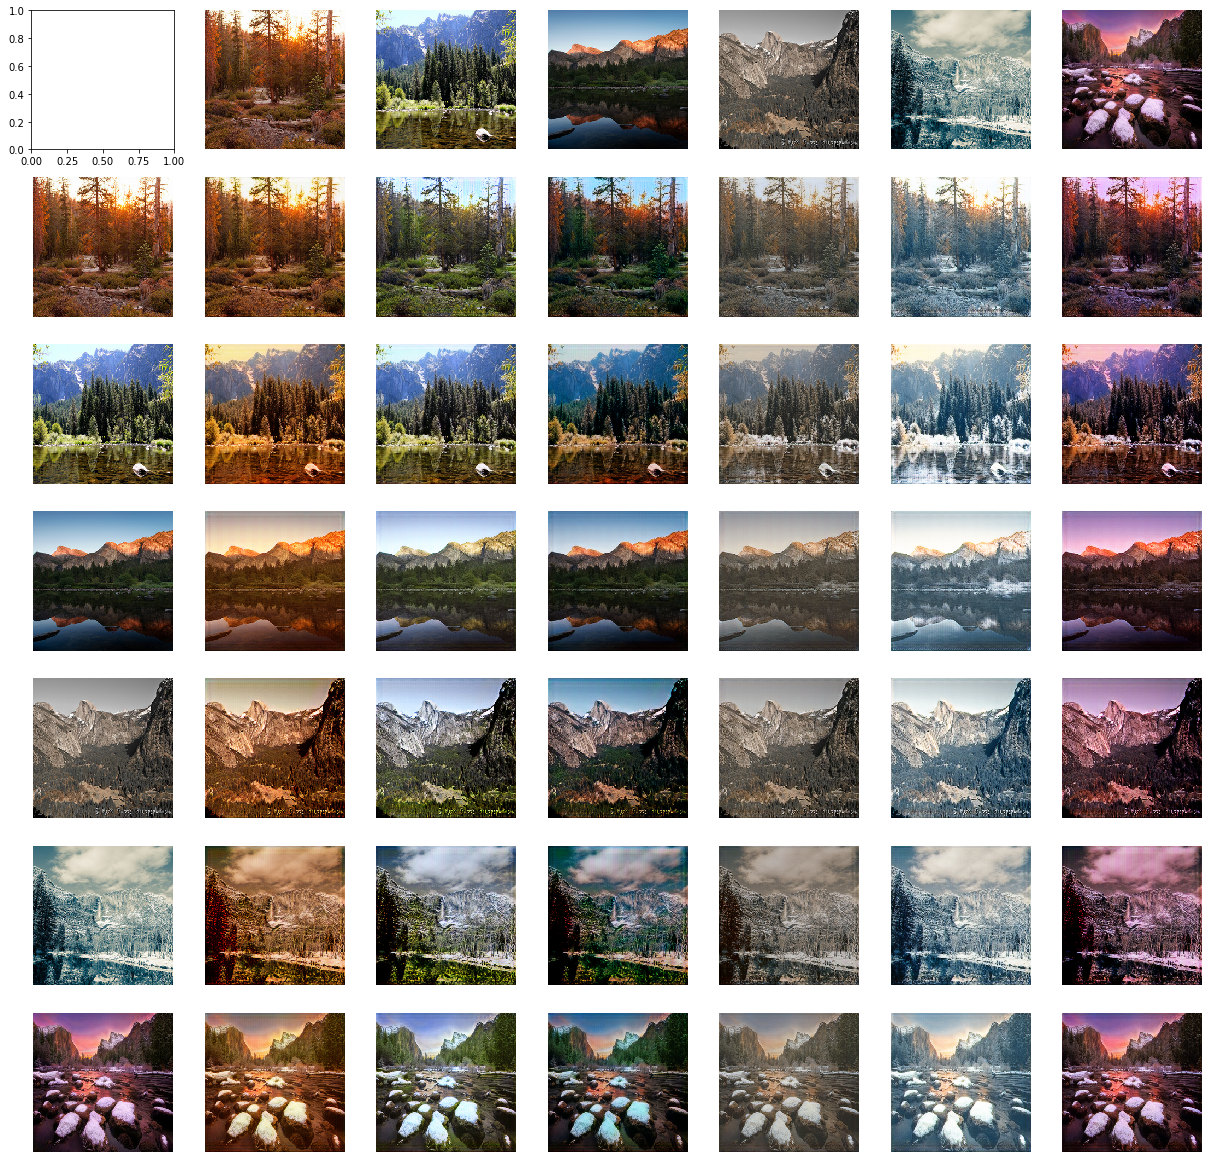

In [10]:
x_list_idx = [120, 130, 138]
y_list_idx = [57, 101, 177]



img_test_x1 = cv2.imread(x_list_test[x_list_idx[0]])
img_test_x2 = cv2.imread(x_list_test[x_list_idx[1]])
img_test_x3 = cv2.imread(x_list_test[x_list_idx[2]])

img_test_y1 = cv2.imread(y_list_test[y_list_idx[0]])
img_test_y2 = cv2.imread(y_list_test[y_list_idx[1]])
img_test_y3 = cv2.imread(y_list_test[y_list_idx[2]])


IMG = {0 : np.expand_dims(img_test_x1,0)}
IMG[1] = np.expand_dims(img_test_x2,0)
IMG[2] = np.expand_dims(img_test_x3,0)
IMG[3] = np.expand_dims(img_test_y1,0)
IMG[4] = np.expand_dims(img_test_y2,0)
IMG[5] = np.expand_dims(img_test_y3,0)

f, ax = plt.subplots(7,7, figsize=(21,21))

for x_idx in range(len(IMG)):
    for s_idx in range(len(IMG)):
        
        if s_idx<3:
            d = 0
        else:
            d = 1
        
        d = np.reshape(d, [-1,1])   
        img_result = sess.run(model.G, feed_dict = {model.x : IMG[x_idx], model.x_s : IMG[s_idx],
                                                   model.d_ : d, model.is_training : False})
        
        img_result = (img_result[0,:,:,:]+1.0)/2
        img_result = np.clip(img_result,0,1)
        
        ax[x_idx+1,s_idx+1].imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
        ax[x_idx+1,s_idx+1].axis('off')
        

for s_domain in range(len(IMG)):
    
    img_result = IMG[s_domain]
    img_result = np.float32(img_result)
    img_result = (img_result[0,:,:,:])/255.
    img_result = np.clip(img_result,0,1)

    ax[0,s_domain+1].imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
    ax[0,s_domain+1].axis('off')

for x_domain in range(len(IMG)):
    
    img_result = IMG[x_domain]
    img_result = np.float32(img_result)
    img_result = (img_result[0,:,:,:])/255.
    img_result = np.clip(img_result,0,1)

    ax[x_domain+1,0].imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
    ax[x_domain+1,0].axis('off')
       
plt.show() 
